#  Evaluating drought effect over the recent years in Morocco using inference on time series Sentinel-2 images of Al Massira dam, the second biggest Dam in Morocco

In this notenook, we wish to use Sentinel-2 satellite images of Al Massira Dam in Morocco taken during the last 10 years to highlight the recent severe drought issue that the country has to  deal with. We will use clouds-aware segmentation model proposed in :

> E. Portalés-Julià, G. Mateo-García, C. Purcell, and L. Gómez-Chova [Global flood extent segmentation in optical satellite images](https://www.nature.com/articles/s41598-023-47595-7). _Scientific Reports 13, 20316_ (2023). DOI: 10.1038/s41598-023-47595-7.
>
>

**Note**: If you run this notebook in Google Colab change the running environment to use a GPU.

## Installing the ml4floods package and authenticating in Google Earth Engine


In [ ]:
!pip install geemap ml4floods
!earthengine authenticate
!pip install mapclassify

In [15]:
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import pandas as pd
import ee
import geemap.foliumap as geemap
from ml4floods.data import ee_download
from shapely.geometry import mapping, shape
import matplotlib.pyplot as plt
from georeader.readers import ee_query, ee_image
from huggingface_hub import hf_hub_download
from ml4floods.scripts.inference import load_inference_function
from ml4floods.models.model_setup import get_channel_configuration_bands
from georeader.readers import S2_SAFE_reader
from georeader.save import save_cog
from ml4floods.scripts.inference import vectorize_outputv1
from georeader import plot
from tqdm import tqdm
from georeader.rasterio_reader import RasterioReader
from georeader.geotensor import GeoTensor
from osgeo import gdal
import numpy as np
import matplotlib.colors
import warnings
import torch
import os

## Using geojson data to define our area of interest and dates to search for S2 images


In [3]:
date_event = datetime.strptime("2014-02-20","%Y-%m-%d").replace(tzinfo=timezone.utc)

date_start_search = datetime.strptime("2014-02-20","%Y-%m-%d").replace(tzinfo=timezone.utc)
date_end_search = date_start_search + timedelta(days=4000)

area_of_interest_geojson = area_of_interest_geojson = {
    'type': 'Polygon',
    'coordinates': (
        (
            (-7.726612201628711, 32.538983003238144),
            (-7.726612201628711, 32.37571862634914),
            (-7.333784506954885, 32.37571862634914),
            (-7.333784506954885, 32.538983003238144),
            (-7.726612201628711, 32.538983003238144),
          ),
        )

}

area_of_interest = shape(area_of_interest_geojson)

## Plot cloud coverage of available S2 images over the area of interest and filter data to get one image per year

Next cell obtains the time series of S2 images over the provided AoI. This is a `ee.ImageCollection` object (`img_col` variable). Afterwards it obtains for each image the time of acquisition (`system:time_start`), the number of valid pixels (`valids`), and the average cloud probability (`cloud_probability`) in a pandas `DataFrame` (`img_col_info_local`). With this dataframe we plot the average cloud probability.

The cloud probability is obtained from the s2cloudless model which [is available in the Google Earth Engine as an independent collection](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY).

Found 1091 S2 images between 2014-02-20T00:00:00+00:00 and 2025-02-02T00:00:00+00:00


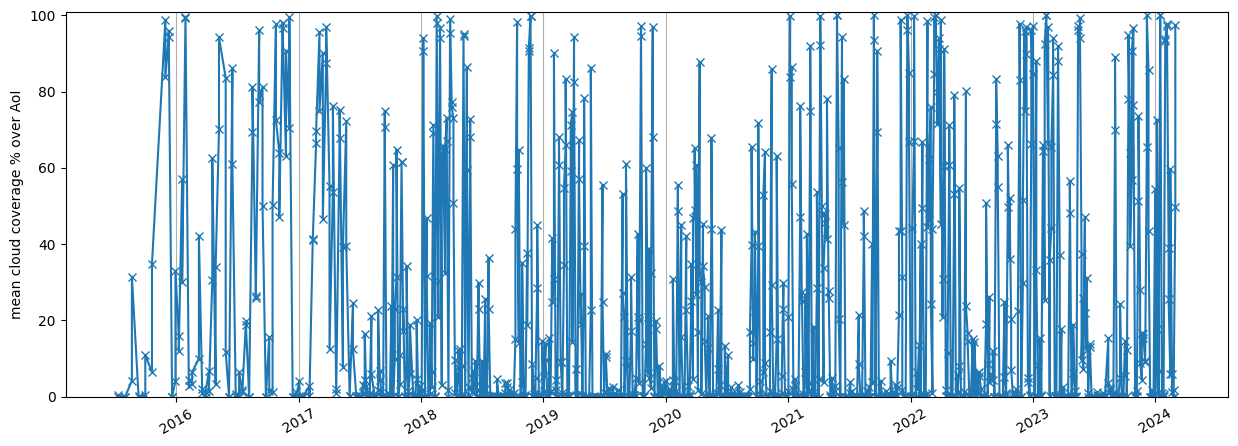

In [4]:
ee.Authenticate()
ee.Initialize(project='principal-iris-416211')

# This function returns a GEE collection of Sentinel-2 and Landsat 8 data and a Geopandas Dataframe with data related to the tiles, overlap percentage and cloud cover
img_col_info_local, img_col = ee_query.query(
    area=area_of_interest,
    date_start=date_start_search,
    date_end=date_end_search,
    producttype="S2",
    return_collection=True,
    add_s2cloudless=False)

# Grab the S2 images and the Permanent water image
n_images_col = img_col_info_local.shape[0]
print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")

plt.figure(figsize=(15,5))
plt.plot(img_col_info_local['utcdatetime'], img_col_info_local['cloudcoverpercentage'],marker="x")
plt.ylim(0,101)
plt.xticks(rotation=30)
plt.ylabel("mean cloud coverage % over AoI")
plt.grid(axis="x")

`DataFrame` with date of acquisition, averaged cloud probability and percentage of valid pixels.

In [ ]:
img_col_info_local.columns

In [ ]:
img_col_info_local['localdatetime'] = pd.to_datetime(img_col_info_local['localdatetime'])  # Convert to datetime format
img_col_info_local = img_col_info_local[img_col_info_local['cloudcoverpercentage'] < 2]

In [ ]:
img_col_info_local = img_col_info_local[(img_col_info_local['localdatetime'].dt.month == 2) | (img_col_info_local['localdatetime'].dt.month == 1)]

In [ ]:
# Assuming df_feb_only is your DataFrame containing entries for the month of February
img_col_info_local['year'] = img_col_info_local['localdatetime'].dt.year

# Group by 'year' and find the entry with the max overlapping percentage
img_col_info_local = img_col_info_local.groupby('year').apply(lambda group: group.loc[group['overlappercentage'].idxmax()])

# Drop the 'year' column if it was added for grouping
img_col_info_local = img_col_info_local.drop(columns=['year'])



In [9]:
n_images_col = img_col_info_local.shape[0]
img_col_info_local.count()

geometry                8
cloudcoverpercentage    8
gee_id                  8
proj                    8
system:time_start       8
collection_name         8
utcdatetime             8
overlappercentage       8
solardatetime           8
solarday                8
localdatetime           8
satellite               8
dtype: int64

In [10]:
img_col_info_local.head()

geometry  cloudcoverpercentage  \
year                                                                            
2017  POLYGON ((-7.93523 32.53286, -7.93523 32.53285...                0.0901   
2018  POLYGON ((-7.93523 32.53286, -7.93523 32.53285...                1.4126   
2019  POLYGON ((-7.93523 32.53286, -7.93523 32.53285...                1.3944   
2020  POLYGON ((-7.93523 32.53286, -7.93523 32.53285...                1.0821   
2021  POLYGON ((-7.93523 32.53286, -7.93523 32.53285...                1.4413   

                                      gee_id  \
year                                           
2017  20170112T111421_20170112T112022_T29SPR   
2018  20180102T111439_20180102T111901_T29SPR   
2019  20190102T111441_20190102T112157_T29SPR   
2020  20200107T111431_20200107T112147_T29SPR   
2021  20210101T111451_20210101T111450_T29SPR   

                                                   proj  system:time_start  \
year                                                                         
2017  {'type': 'Projection', 'crs': 'EPSG:32629', 't...      1484220022847   
2018  {'type': 'Projection', 'crs': 'EPSG:32629', 't...      1514891941830   
2019  {'type': 'Projection', 'crs': 'EPSG:32629', 't...      1546428140070   
2020  {'type': 'Projection', 'crs': 'EPSG:32629', 't...      1578396140336   
2021  {'type': 'Projection', 'crs': 'EPSG:32629', 't...      1609500146086   

               collection_name                      utcdatetime  \
year                                                              
2017  COPERNICUS/S2_HARMONIZED 2017-01-12 11:20:22.847000+00:00   
2018  COPERNICUS/S2_HARMONIZED 2018-01-02 11:19:01.830000+00:00   
2019  COPERNICUS/S2_HARMONIZED 2019-01-02 11:22:20.070000+00:00   
2020  COPERNICUS/S2_HARMONIZED 2020-01-07 11:22:20.336000+00:00   
2021  COPERNICUS/S2_HARMONIZED 2021-01-01 11:22:26.086000+00:00   

      overlappercentage                    solardatetime    solarday  \
year                                                                   
2017          93.043883 2017-01-12 10:50:56.496656+00:00  2017-01-12   
2018          93.043883 2018-01-02 10:49:35.479656+00:00  2018-01-02   
2019          93.043883 2019-01-02 10:52:53.719656+00:00  2019-01-02   
2020          93.043883 2020-01-07 10:52:53.985656+00:00  2020-01-07   
2021          93.043883 2021-01-01 10:52:59.735656+00:00  2021-01-01   

                        localdatetime satellite  
year                                             
2017 2017-01-12 11:20:22.847000+00:00       S2A  
2018 2018-01-02 11:19:01.830000+00:00       S2B  
2019 2019-01-02 11:22:20.070000+00:00       S2A  
2020 2020-01-07 11:22:20.336000+00:00       S2A  
2021 2021-01-01 11:22:26.086000+00:00       S2A

## Display S2 images over the area of interest


In [11]:
import geemap.foliumap as geemap
import folium

tl = folium.TileLayer(
            tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
            attr='Google',
            name="Google Satellite",
            overlay=True,
            control=True,
            max_zoom=22,
        )

m = geemap.Map(location=area_of_interest.centroid.coords[0][-1::-1],
               zoom_start=8)

tl.add_to(m)

img_col_info_local["localdatetime_str"] = img_col_info_local["localdatetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
showcolumns = ["geometry","overlappercentage","cloudcoverpercentage", "localdatetime_str","solarday","satellite"]
colors = ["#ff7777", "#fffa69", "#8fff84", "#52adf1", "#ff6ac2","#1b6d52", "#fce5cd","#705334"]

# Add the extent of the products
for i, ((day,satellite), images_day) in enumerate(img_col_info_local.groupby(["solarday","satellite"])):
    images_day[showcolumns].explore(
        m=m,
        name=f"{satellite}: {day} outline",
        color=colors[i % len(colors)],
        show=False)

# Add the S2 data
for (day, satellite), images_day in img_col_info_local.groupby(["solarday", "satellite"]):
    if images_day.cloudcoverpercentage.mean() >= 50:
        continue

    image_col_day_sat = img_col.filter(ee.Filter.inList("title", images_day.index.tolist()))
    bands = ["B11","B8","B4"] if satellite.startswith("S2") else ["B6","B5","B4"]
    m.addLayer(image_col_day_sat,
               {"min":0, "max":3000 if satellite.startswith("S2") else 0.3, "bands": bands},
               f"{satellite}: {day}",
               False)

aoi_gpd = gpd.GeoDataFrame({"geometry": [area_of_interest]}, crs= "EPSG:4326",geometry="geometry")
aoi_gpd.explore(style_kwds={"fillOpacity": 0}, color="black", name="AoI", m=m)
folium.LayerControl(collapsed=False).add_to(m)
m

## Load the model

In [12]:
experiment_name = "WF2_unetv2_bgriswirs"
subfolder_local = f"models/{experiment_name}"
config_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="config.json",
                              local_dir=".", local_dir_use_symlinks=False)
model_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="model.pt",
                              local_dir=".", local_dir_use_symlinks=False)

inference_function, config = load_inference_function(subfolder_local, device_name = 'cpu', max_tile_size=1024,
                                                     th_water=0.5, th_brightness=3500,
                                                     distinguish_flood_traces=True)

channel_configuration = config['data_params']['channel_configuration']
channels  = get_channel_configuration_bands(channel_configuration, collection_name='S2')

def predict(input_tensor, channels = [1, 2, 3, 7, 11, 12] ):
    input_tensor = input_tensor.astype(np.float32)
    input_tensor = input_tensor[channels]
    torch_inputs = torch.tensor(np.nan_to_num(input_tensor))
    return inference_function(torch_inputs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


models/WF2_unetv2_bgriswirs/config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

Loaded model weights: models/WF2_unetv2_bgriswirs/model.pt
Getting model inference function


## Download the images, run inference and vectorize the outputs

  0%|          | 0/8 [00:00<?, ?it/s]

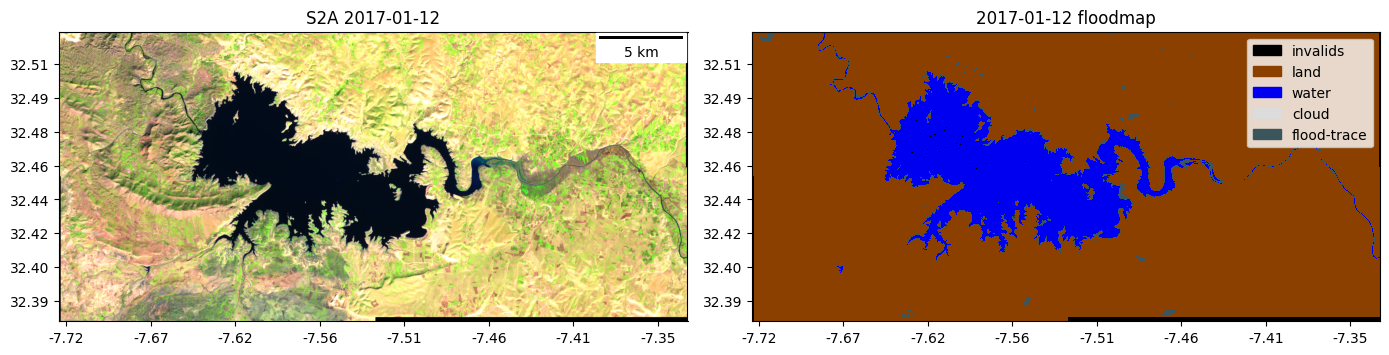

 12%|█▎        | 1/8 [00:23<02:46, 23.75s/it]

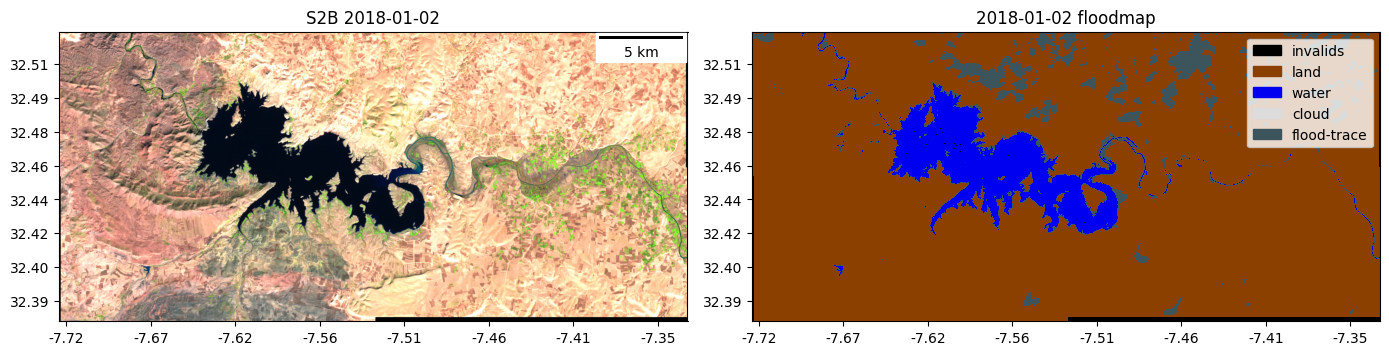

 25%|██▌       | 2/8 [00:43<02:07, 21.31s/it]

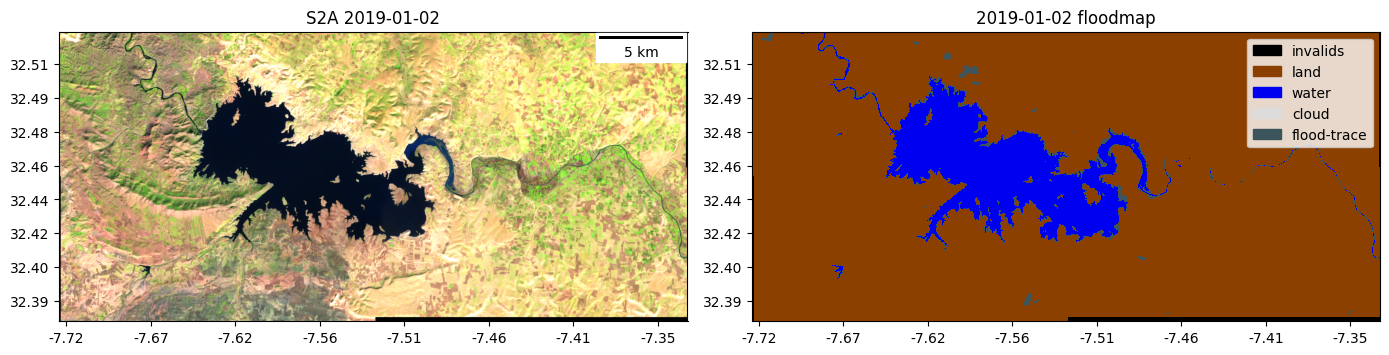

 38%|███▊      | 3/8 [01:01<01:40, 20.06s/it]

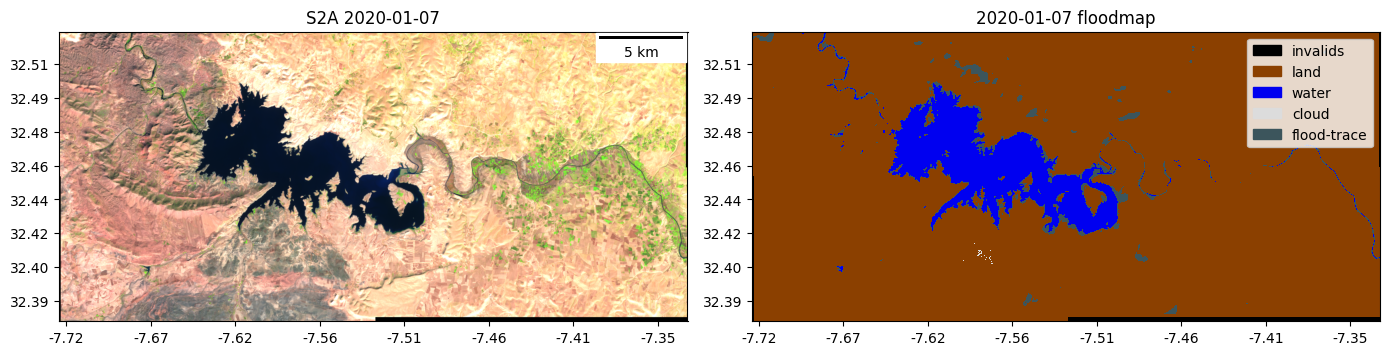

 50%|█████     | 4/8 [01:25<01:25, 21.44s/it]

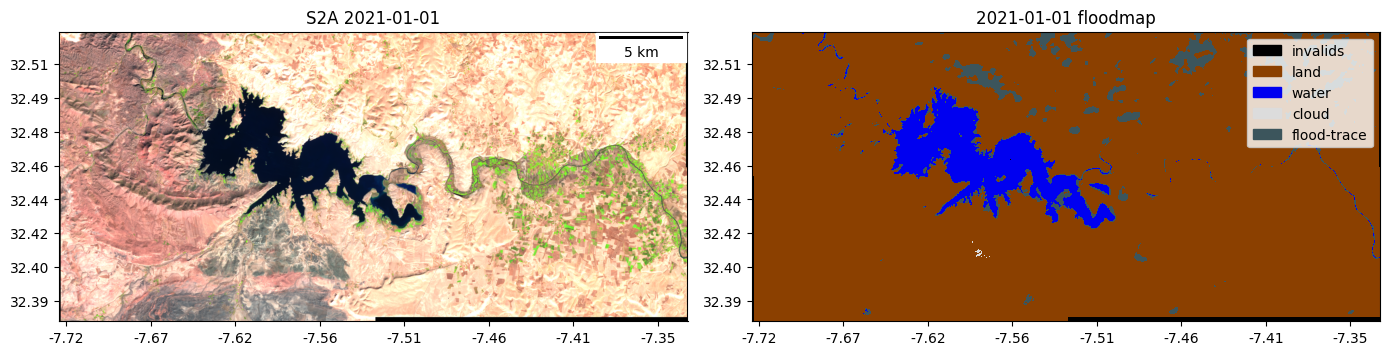

 62%|██████▎   | 5/8 [01:47<01:04, 21.50s/it]

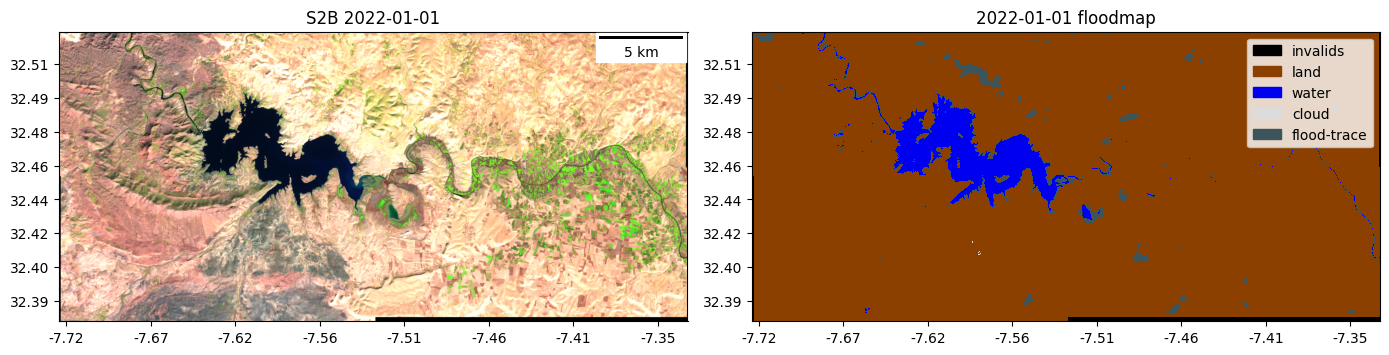

 75%|███████▌  | 6/8 [02:06<00:41, 20.69s/it]

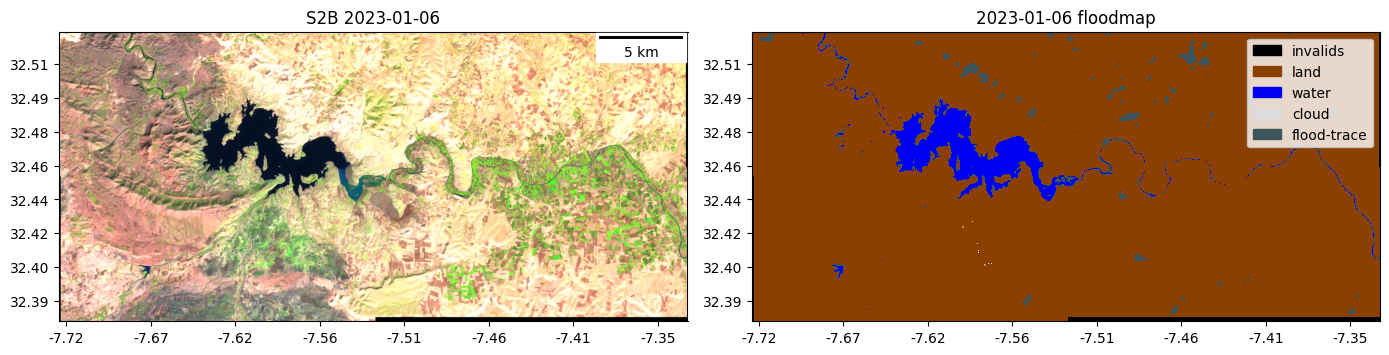

 88%|████████▊ | 7/8 [02:24<00:19, 19.83s/it]

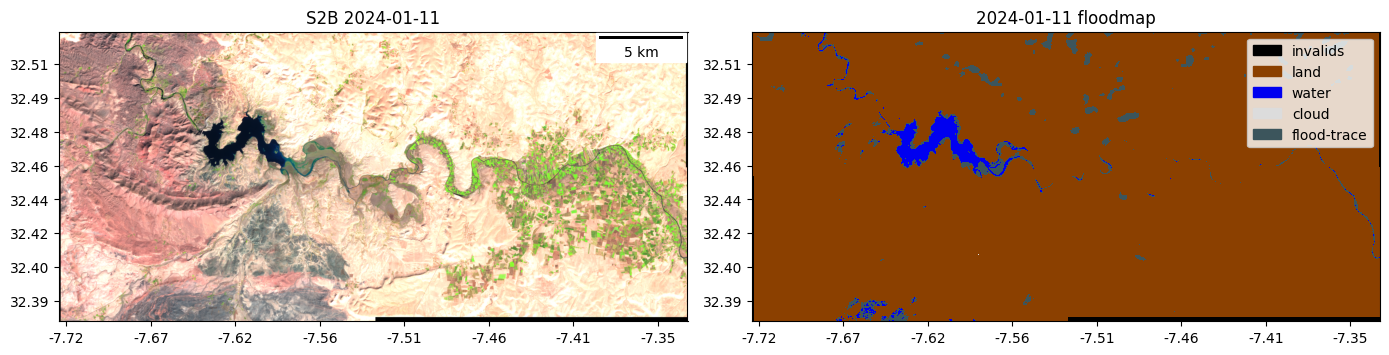

100%|██████████| 8/8 [02:43<00:00, 20.41s/it]


In [16]:
gdal.PushErrorHandler('CPLQuietErrorHandler')
COLORS_PRED = np.array([[0, 0, 0], # 0: invalid
                       [139, 64, 0], # 1: land
                       [0, 0, 240], # 2: water
                       [220, 220, 220], # 3: cloud
                       [60, 85, 92]], # 5: flood_trace
                    dtype=np.float32) / 255

band_names_S2  = get_channel_configuration_bands(channel_configuration, collection_name='S2', as_string=True)
path_to_export = "cache_s2"
os.makedirs(path_to_export, exist_ok=True)

floodmaps = {}
for i in tqdm(range(n_images_col), total=n_images_col):
    s2data = img_col_info_local.iloc[i]
    if s2data.cloudcoverpercentage > 50:
        continue

    date = s2data.solarday
    filename = os.path.join(path_to_export,f"albania_ts_{date}.tif")
    filename_pred = os.path.join(path_to_export,f"albania_ts_{date}_pred.tif")
    filename_jpg = os.path.join(path_to_export,f"albania_ts_{date}.jpg")
    filename_gkpg = os.path.join(path_to_export,f"albania_ts_{date}.gpkg")

    # Download S2 image
    if not os.path.exists(filename):
        asset_id = f"{s2data.collection_name}/{s2data.gee_id}"
        geom = s2data.geometry.intersection(area_of_interest)
        postflood = ee_image.export_image_getpixels(asset_id, geom, proj=s2data.proj,bands_gee=band_names_S2)
        save_cog(postflood, filename, descriptions=band_names_S2)
    else:
        postflood = RasterioReader(filename).load()

    # Run inference
    if not os.path.exists(filename_pred):
        prediction_postflood, prediction_postflood_cont  = predict(postflood.values, channels = list(range(len(band_names_S2))))
        prediction_postflood_raster = GeoTensor(prediction_postflood.numpy(), transform=postflood.transform,
                                            fill_value_default=0, crs=postflood.crs)
        save_cog(prediction_postflood_raster, filename_pred, descriptions=["floodmap"])
    else:
        prediction_postflood_raster = RasterioReader(filename_pred).load().squeeze()

    # Plot
    fig, ax = plt.subplots(1,2,figsize=(14,4.75), tight_layout=True)
    plot.show((postflood.isel({"band": [4,3,2]})/3_500).clip(0,1), ax=ax[0], add_scalebar=True)
    ax[0].set_title(f"{s2data.satellite} {s2data.solarday}")
    plot.plot_segmentation_mask(prediction_postflood_raster, COLORS_PRED, ax=ax[1],
                                interpretation_array=["invalids", "land", "water", "cloud", "flood-trace"])
    ax[1].set_title(f"{s2data.solarday} floodmap")
    plt.show(fig)
    fig.savefig(filename_jpg)
    plt.close(fig)

    # Vectorize the predictions
    postflood_shape = vectorize_outputv1(prediction_postflood_raster.values,
                                         prediction_postflood_raster.crs,
                                         prediction_postflood_raster.transform)
    floodmaps[s2data.solarday] = postflood_shape
    postflood_shape.to_file(filename_gkpg, driver='GPKG')

